<a href="https://colab.research.google.com/drive/12eELxXKxruNWfwSWmFQlpWX9nZlkl2IO?usp=sharing" target="_blank" >
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

In [22]:
# Import necessary libraries

import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Load the ResNet50 model from keras with "imagenet" weights

model = ResNet50(include_top=True,weights="imagenet")

In [24]:
# Specify the image height and width as per imagenet stats
image_height, image_width = 224, 224

# custom function to load the image 
def load_image(path, preprocess=True):
    x = image.load_img(path, target_size=(image_height, image_width))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

# Function to process gradients for viewing
def deprocess_image(x):
# From here: https://github.com/eclique/keras-gradcam/blob/master/grad_cam.py
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    x = np.flip(x,axis=-1)
    return x


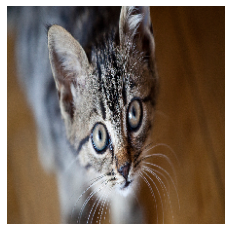

In [9]:
# Origin image

plt.imshow(load_image("./cat.png", preprocess=False))
plt.axis("off");

In [26]:
preprocessed_input = load_image("./cat.png")
preprocessed_input.shape

(1, 224, 224, 3)

In [120]:
# Load the print the original image from the file cat.png
# Decorator function to change the Relu functionality 

@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad


# @tf.custom_gradient
# def guidedRelu(x):
#   def grad(dy):
#     return dy
#   return tf.nn.relu(x), grad

model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)
activation_model = Model(
    inputs = [model.inputs],
    # Last convolution layer in RESNET50 is conv5_block3_out
    outputs = [model.get_layer("conv5_block3_out").output]
)

# Modifying layers with Relu activation
layer_dict = [layer for layer in activation_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu
# for layers in model.layers:
#   if  layers == tf.keras.activations.relu:
#     print(1)
#     layers.activation = guidedRelu
# Performing the backpropagation step

with tf.GradientTape() as tape:
  inputs = tf.cast(preprocessed_input, tf.float32)
  tape.watch(inputs)
  outputs = activation_model(inputs)

grads = tape.gradient(outputs,inputs)[0]

ValueError: ignored

In [108]:
# # Modifying layers with Relu activation
# layer_dict = [layer for layer in activation_model.layers[1:] if hasattr(layer,'activation')]
# for layer in layer_dict:
#   if layer.activation == tf.keras.activations.relu:
#     layer.activation = guidedRelu

for layer in activation_model.layers:
  if hasattr(layer,'activation') and layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu
# Performing the backpropagation step

with tf.GradientTape() as tape:
  inputs = tf.cast(preprocessed_input, tf.float32)
  tape.watch(inputs)
  outputs = activation_model(inputs)

grads = tape.gradient(outputs,inputs)[0]


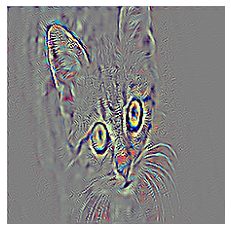

In [109]:
# Define the activation_model using the model inputs and output of 
# the last convolutional layer
plt.imshow(deprocess_image(np.array(grads)))
plt.axis("off");

# New Section